# Weighing Options In The Public Sector
## An Exploration of Oregon Government Jobs

If I decided to get a "real" job, and stop being an IT contractor, working in the public sector is an option. I know they get decent benefits, but there are a lot of factors to weigh. This is an exploration of government jobs and salaries pulled from Oregon's government transparancy website.

## Some Assumptions and Caveats

- This data is real life and economic based (which is to say, messy as hell):
  - We will be using an alpha of 0.05, (this ain't physics).
  - When we use confidence intervals, we'll keep it to 90%, (when was the last time you were more than 90% sure of something irl?)
- I will *try* not to just assume a normal distribution without explicitly saying so otherwise (I'll still make this assumption a lot). Again this stuff is messy, very little of the underlying distributions are perfectly or even roughly normal distributions:  

- There is too much data to be working with by hand (27MB):
  - I will be making heavy use of R to do the work for me for this presentation.
  - I will mostly only display relevent results.
- I'm on a schedule:
  - I don't *really* know R's syntax, grammer, builtin functions or syntatical sugar. I'll put in some code comments to explain what I'm doing but this code will be hacky. **Don't judge me**.
  - Where I can (*and if it's not too annoying*), I'll try and show some of the calculations in longer form.
- This is for class. I'm trying to show I learned anything, sometimes the data makes that hard to do:
  - Where appropriate (or not too egregious) I **will** randomly sample from populations and just assume it's normal (*or if it's just convienient—sue me*).
  - I make no promises more that "mostly accurate". **Don't** make life decisions based on what I've done here.
  - If you want accuracy go read five-thirty-eight or something.



In [1]:
# Import the data and lowercase the column names
options(warn=-1)
set.seed(99)
SAL <-read.csv("Salaries_of_State_Agencies_-_Multi-Year_Report.csv", header=T)
names(SAL) <- tolower(names(SAL))

In [2]:
SAL[12:20,]

,fiscal.year,agency,classification,salary.annual,full.part.time,service.type,agency.1
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>
12,2015,"CORRECTIONS, DEPT OF",DENTIST,176352,JOB SHARE,REPRESENTED,29100
13,2015,"CORRECTIONS, DEPT OF",DENTIST,176352,PART TIME,REPRESENTED,29100
14,2015,"CORRECTIONS, DEPT OF",WELDER 2,70494,FULL TIME,REPRESENTED,29100
15,2015,"CORRECTIONS, DEPT OF",WELDER 2,70806,FULL TIME,REPRESENTED,29100
16,2015,"EDUCATION, DEPT OF",CUSTODIAN,31632,PART TIME,REPRESENTED,58100
17,2015,"EDUCATION, DEPT OF",CUSTODIAN,31632,PART TIME,REPRESENTED,58100
18,2015,"EDUCATION, DEPT OF",CUSTODIAN,31632,PART TIME,REPRESENTED,58100
19,2015,"YOUTH AUTHORITY, OREGON",FISCAL ANALYST 2,69624,FULL TIME,REPRESENTED,41500
20,2015,"YOUTH AUTHORITY, OREGON",FISCAL ANALYST 3,62772,FULL TIME,EXECUTIVE SERVICE,41500


In [3]:
attach(SAL)

In [4]:
library(stringr) # a regex and string manipulation library

# Clean some relevent data and put it back in
classification <- str_replace(SAL$classification, "TECHNICIAN", "TECH")
classification <- str_replace(classification, "SPEC$", "SPECIALIST")
classification  <- str_replace(classification, "SUPV", "SUPERVISOR")
SAL$classification = classification

# add another column to allow me to group the same jobs together
GEN_CLASS  <- str_extract(classification, "(.+)[^\\s|\\d|I]")
SAL$gen_class <- GEN_CLASS
SAL[12:20,]

,fiscal.year,agency,classification,salary.annual,full.part.time,service.type,agency.1,gen_class
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>
12,2015,"CORRECTIONS, DEPT OF",DENTIST,176352,JOB SHARE,REPRESENTED,29100,DENTIST
13,2015,"CORRECTIONS, DEPT OF",DENTIST,176352,PART TIME,REPRESENTED,29100,DENTIST
14,2015,"CORRECTIONS, DEPT OF",WELDER 2,70494,FULL TIME,REPRESENTED,29100,WELDER
15,2015,"CORRECTIONS, DEPT OF",WELDER 2,70806,FULL TIME,REPRESENTED,29100,WELDER
16,2015,"EDUCATION, DEPT OF",CUSTODIAN,31632,PART TIME,REPRESENTED,58100,CUSTODIAN
17,2015,"EDUCATION, DEPT OF",CUSTODIAN,31632,PART TIME,REPRESENTED,58100,CUSTODIAN
18,2015,"EDUCATION, DEPT OF",CUSTODIAN,31632,PART TIME,REPRESENTED,58100,CUSTODIAN
19,2015,"YOUTH AUTHORITY, OREGON",FISCAL ANALYST 2,69624,FULL TIME,REPRESENTED,41500,FISCAL ANALYST
20,2015,"YOUTH AUTHORITY, OREGON",FISCAL ANALYST 3,62772,FULL TIME,EXECUTIVE SERVICE,41500,FISCAL ANALYST


# Getting My Feet Wet: Creeping On People I Met Once
## Which Dept. Did That Woman I Met Work At?

I met a woman at a python conference in early 2020. She said she worked or had worked for the government as an analyst—I can't remember which. We talked about what we did for a while, and I asked how well her job payed; she said that she made "around 65 grand" per year. 

To do this analysis, we're gonna make some assumptions and pretend some stuff.

- analyst pay in each dept is normally distributed (it probably isn't exactly, but a look at some graphs look roughly normal, good enough for me)
- Pretend I **don't** have access to the full population dataset

We're gonna pretend that I went to each department and asked 10 analyists what they made. Also I'll pretend that I did this over the period from 2015-2020 (all samples randomly and indepently chosen). We'll use that to estimate the distribution for each department.

## Step 1: Filter the data

In [5]:
# Filter on what we're looking for
analysts = SAL[str_detect(SAL$gen_class, "ANALYST")&fiscal.year<=2020 & full.part.time=="FULL TIME",]

# We'll only use departments that have more than 10 analyists, can't get 10 samples otherwise.

counts = as.data.frame(table(analysts$agency))
dept_names = counts[counts[2]>=10, 1]


analysts = analysts[analysts$agency %in% dept_names, c("agency", "salary.annual") ]

## Step 2: See If There's Even A Difference Between The Average Salaries In Each Department

To do this, we're going to conduct an anova test. For this test we are going to assume:
  1. Each departments salary distribution is normal (same as we said above)
  2. Each departments standard deviation is the same (Not something we're really confident about)

The groups for the anova test are going to be the departments. 
Here are our hypotheses:

H0: each department pays their analysts the same on average.

HA: each department does **not** pay their analysts the same on average.

In [6]:
# function to build a df of 10 samples for each department (long form), no pivot

samp10 <- function(data, dept_names){
    new = data.frame(dept=character(0), sample=numeric(0))
    for (name in dept_names){
        salaries = data[data$agency == name,2]
        for(x in 1:10){
            r = floor(runif(1, min=1, max=length(salaries)))
            row = list(name, salaries[r])
            salaries = salaries[-r]
            new[nrow(new)+1,] = row
        }
    }
    new
}

samples = samp10(analysts, dept_names)

model = lm(sample~dept, samples)

anova(model)


,Df,Sum Sq,Mean Sq,F value,Pr(>F)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>
dept,55,79328877331,1442343224,6.126613,2.759689e-30
Residuals,504,118653001472,235422622,NA,NA


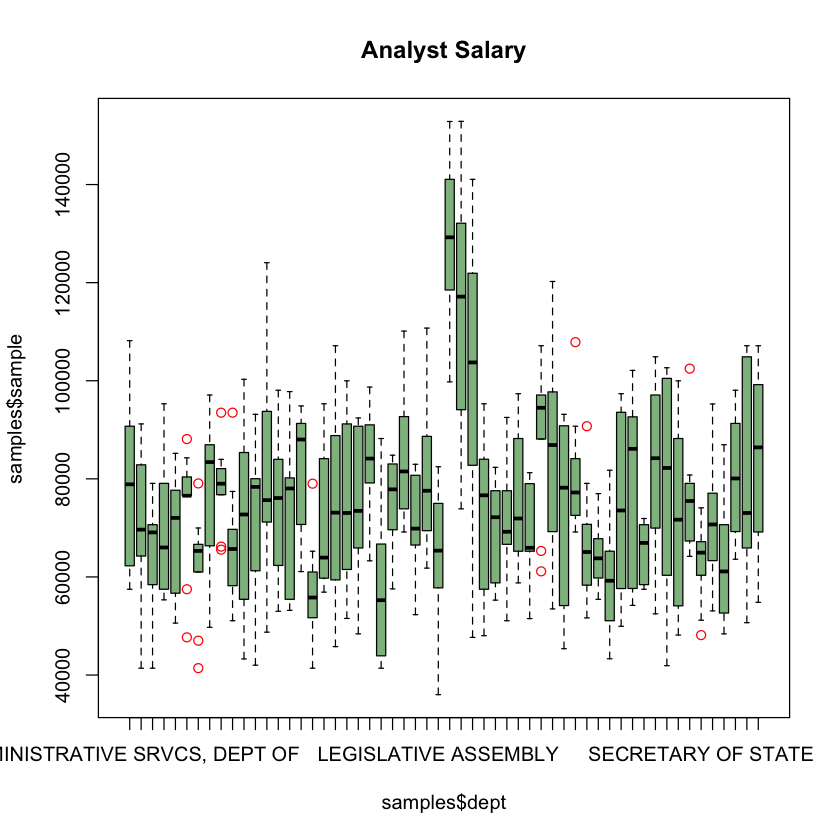

In [7]:
# Let's see if this answer makes any sense
# We'll make boxplots for the samples of each department and see if we can get anything out of it

boxplot(samples$sample~samples$dept, col="darkseagreen", outcol="red", main="Analyst Salary")

It's pretty clear looking at the graph that there is quite a lot of variance in the mean pay among the departments, With 2 particular outliers in the middle.

## Step 3: In Comes The Bayes 

In [8]:
# make a table of the estimated normal distribution values (N{Ybar_i, S_i^2}) for each department given their samples

dfs = split(samples, samples$dept)
params = data.frame(agency=character(), avg=numeric(), sd=numeric())
for (df in dfs){
    params[nrow(params)+1,] = list(df$dept[1], mean(df$sample), sd(df$sample))
}

# decide on an acceptible range we'll say +- 2 grand from what she said, why not
# we'll add on a new row that contains the probabilty of getting a salary between 63000 and 67000 for each department

probs = numeric(nrow(params))

for (i in  1:nrow(params)){
    m = params[i, "avg"]
    sd = params[i, "sd"]
    probs[i] = pnorm(67000, m, sd) - pnorm(63000, m, sd)
}
# add a column representing the probability of getting that salary given she works in that department
params$p_sal_g_dpt = probs
head(params)



,agency,avg,sd,p_sal_g_dpt
,<chr>,<dbl>,<dbl>,<dbl>
1,"ADMINISTRATIVE SRVCS, DEPT OF",77948.4,16785.40,0.07053486
2,"AGRICULTURE, DEPT OF",71245.2,14785.26,0.09847170
3,"AVIATION, DEPARTMENT OF",64823.1,12195.19,0.13025460
4,"BLIND, COMMISSION FOR THE",70572.0,13809.25,0.10621267
5,CHIEF EDUCATION OFFICE,69051.6,11633.74,0.12853961
6,COMM COLL/WRKFRCE DEV OFFICE,74422.3,12343.27,0.09642987


In [9]:
# Now we'll calculate the conditional probability (bayes) of Pr{agency|department} for each department

# to calculate the raw probabilty of being from each department, we need to calculate the proportion
# of analysts in each department

total_analysts = nrow(analysts)
p_dpt = numeric(nrow(params))
for (i in 1:nrow(params)){
    dpt = params[i, 1]
    a_in_dpt = nrow(analysts[analysts$agency==dpt,])
    p_dpt[i] = a_in_dpt / total_analysts
}
# a row representing the probabilty of being from each department
params$p_dpt = p_dpt

# now we calculate the overall probability of a random person getting that salary
p_sal = sum(params$p_dpt * params$p_sal_g_dpt)

# And do the bayes calculation
params$p_dpt_g_sal = params$p_sal_g_dpt * p_dpt / p_sal

# as a sanity check, we'll see if all the conditional probabilities sum to 1 (she has to be from one of them)
cat("All conditional probs sum to 1: ",sum(params$p_dpt_g_sal) == 1)

# and lets take a look!
tail(params[order(params$p_dpt_g_sal),c(1, 6)])

All conditional probs sum to 1:  TRUE

,agency,p_dpt_g_sal
,<chr>,<dbl>
1,"ADMINISTRATIVE SRVCS, DEPT OF",0.03561180
8,"CONSUMER AND BUS SRVCS, DEPT",0.03643026
46,PUBLIC EMPS RETIREMENT SYSTEM,0.06175604
52,"TRANSPORTATION, DEPT OF",0.10322827
39,OREGON HEALTH AUTHORITY,0.18219138
21,"HUMAN SERVICES, DEPARTMENT OF",0.21858462


[1] "Hand Calculations and R agree!"
The Corrolation coeficient "r" for these two variables is  0.9829046

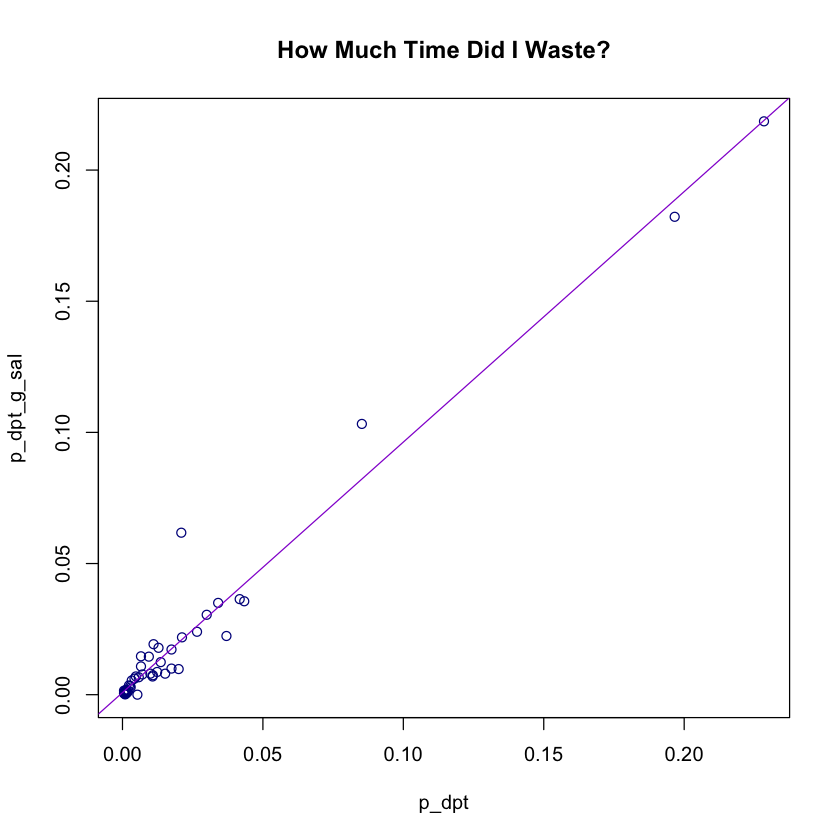

In [10]:
# Out of curiosity, lets take a quick look at how well the size of the department and the probabilty of
# Getting some department given that salary are corrolated
# in otherwords, could we just have looked at the analysts proportions and gotten a reasonable result?

# I'll calculate r by "hand" and use R to double check my work

x = params$p_dpt
y = params$p_dpt_g_sal
xhat = mean(x)
yhat = mean(y)
sx = sd(x)
sy = sd(y)

err_x = (x-xhat)/sx
err_y = (y-yhat)/sy

r = sum(err_x*err_y) / (length(x)-1)

# Check my work
if(r - cor(x, y) <= 3e-16){  # difference is within floating precision error
    print("Hand Calculations and R agree!")
}

cat("The Corrolation coeficient \"r\" for these two variables is ",r)

# May as well graph it too. Everyone likes graphs.
fit = lm(p_dpt_g_sal ~ p_dpt, params)
plot(p_dpt_g_sal ~ p_dpt, params, main="How Much Time Did I Waste?", col="darkblue")
abline(fit, col="darkviolet")

Yep, an almost perfect positive corrolation. We could have saved a ton of work if we had just looked at the porportions of total analysts. A little depressing.

# Now It's All About ME
Now that I've become a little more familiar with the data, it's time to do some statistics that help answer my more pressing concerns. Is it worth it for me to try to get into the public sector?

# Will The Public Sector Even Be Hiring?

### Overall Year-Over-Year Job Growth

First things first, will there even be enough growth in the govenment for me to get hired?

Job Growth Estimate:  1013.798 


90% confidence interval for job growth: [ 295.7503 1731.845 ]


Expected new jobs in 2023:  -2351 


P-value:  0.033577805792559

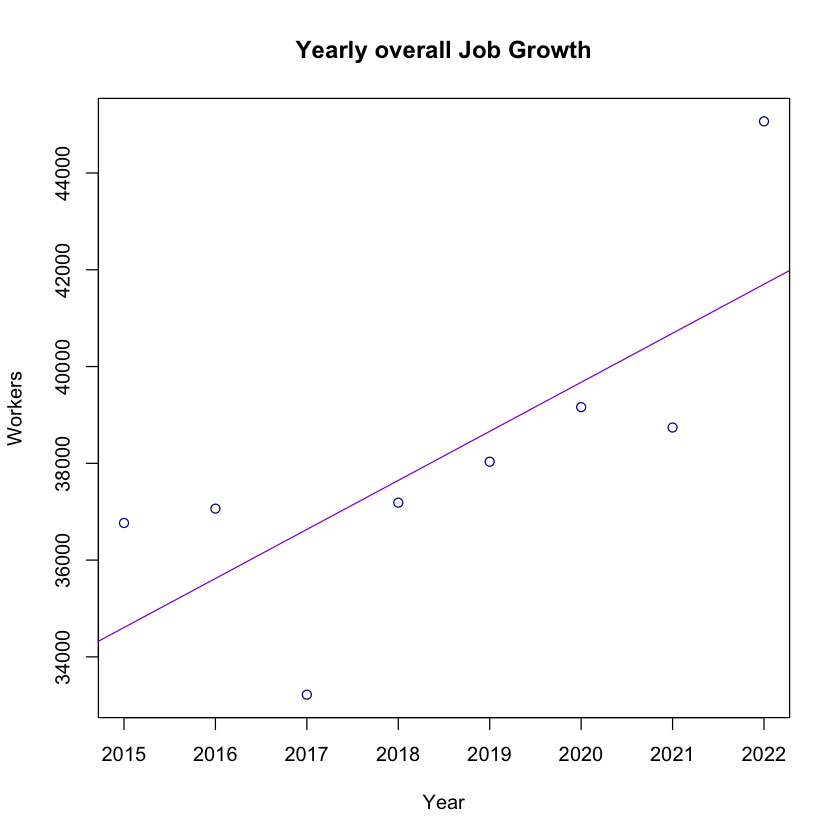

In [11]:
# group all employes by year and make a table and a linear regression
years = split(SAL, SAL$fiscal.year)


employees <- function(dfs){  # Extracts the number of employees from a set of dataframes
    counts = numeric(length(dfs))
    for (i in 1:length(dfs)){
        f = dfs[[i]]
        counts[i] = nrow(f)
    }
    counts
}


emp = employees(years)
emp = data.frame(Year = 1:length(emp)+2014, Workers=emp)
lrg = lm(Workers~Year, data=emp)
summ = summary(lrg)
# Growth estimate
cat("Job Growth Estimate: ", summ$coefficients[2, 1], "\n\n")

# Calculate confidence interval:
#    Pulling out Values from linear model summary, because I'm lazy

sderr = summ$coefficients[2, 2]
b1 = summ$coefficients[2, 1]
tda = qt(0.95, nrow(emp)-2)
#tval (found at summ$coefficients[2,3] (I'll do it below, for now))

#    calc interval

ci = c(b1 - tda * sderr, b1 + tda * sderr) # more easily done with confint(lrg, level=%)[2,]
cat("\n90% confidence interval for job growth: [", ci, "]\n")

# How many new jobs can I expect to be added next year?
expected2023 = predict(lrg, data.frame(Year=2023))
jobs2022 = emp[8,2]
cat("\n\nExpected new jobs in 2023: ", as.integer(expected2023 - jobs2022), "\n")


# Plot with trend
#emp
plot(emp, main="Yearly overall Job Growth", col="darkblue")
abline(lrg, col="darkviolet")

# Calc P val (found at summ$coefficients[2,4], if you don't feel like doing it yourself)
tstat = (b1-0)/sderr
pval = 2 * pt(-tstat, nrow(emp)-2)
cat(paste("\n\nP-value: ", pval))


- It looks like we may expect OR to *lose* about 2300 jobs next year. This is likely because 2023 seems to be an outlier in growth. Wheter this will be the case that 2023 will be a regression to the mean, or that 2023 will be the start of a new boom in jobs (something that will make us increase our growth predictions) is anyone's guess.

- We are 95% certain that they will add on between 295 and 1731 additional jobs on average year-over-year. Our predictive precision here is not that great.

- our p-value indicates that with our alpha of 0.05, and a p-value of 0.0336, we can conclude that on average they are indeed growing their workforce. 

- Growth is growth, but maybe I should hold off on applying for a job next year.

# Which Departments Are Experiencing Positive Average Growth

In [12]:
# Break down data by dept
depts = split(SAL, SAL$agency)

# use dept data, break them down by year and make a fit line for all of them
find_best_depts <- function(depts){
    data = data.frame(Dept=character(), Growth=numeric())
    for (dept in depts){
        by_year = split(dept, dept$fiscal.year)
        jobs_by_year = employees(by_year)
        df = data.frame(year=1:length(jobs_by_year), jobs = jobs_by_year)
        if (nrow(df)>1){
            fit = lm(jobs~year, df)
            summ = summary(fit)
            b1 = summ$coefficients[2,1]
            pval = summ$coefficients[2,4]
            # only include positive growth that we're confident in
            if (!is.nan(pval) & pval <= 0.05 & b1 > 0){
                data[nrow(data)+ 1,] = list(dept[1,2], b1)
            }
        }
    }
    data
}
growing_depts = find_best_depts(depts)
growing_depts = growing_depts[order(growing_depts$Growth),]
tail(growing_depts)


,Dept,Growth
,<chr>,<dbl>
9,"HOUSING & COMM SRVCS, DEPT OF",19.00000
1,"ADMINISTRATIVE SRVCS, DEPT OF",19.75000
18,"POLICE, OREGON STATE",19.90476
4,"EDUCATION, DEPT OF",26.94048
5,EMPLOYMENT DEPT,157.70238
10,"HUMAN SERVICES, DEPARTMENT OF",429.65476


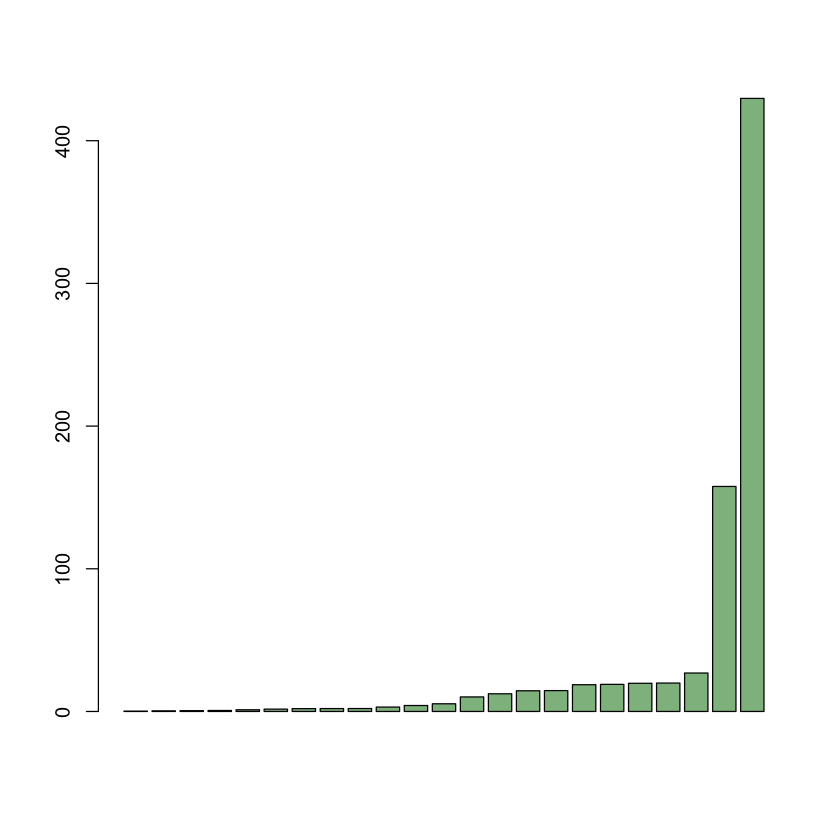

In [13]:
barplot(growing_depts$Growth, col="darkseagreen")

Growth seems to be heavily concentrated almost exponentially in certain departments

# Looking At Jobs I'm Willing And Qualified To Work

In [14]:
# Extract the jobs I'm qualified for and am willing to do
QUAL <- SAL$gen_class == "ACCOUNTING TECH"|GEN_CLASS == "ADMINISTRATIVE ANALYST"|GEN_CLASS == "APPLICATIONS DEVELOPER"|GEN_CLASS == "APPLICATIONS SYSTEMS MANAGER"|GEN_CLASS == "ARCHIVIST"|GEN_CLASS == "ASSOCIATE IN GEOLOGY"|GEN_CLASS == "CLERICAL ASSISTANT"|GEN_CLASS == "COMPUTER SVCS COORDINATOR"|GEN_CLASS == "CONTRACT MANAGER"|GEN_CLASS == "CUSTODIAN"|GEN_CLASS == "CUSTOMER ENGAGEMENT MANAGER"|GEN_CLASS == "DATA ENTRY CONTROL TECH'⋯'REHABILITATION THERAPY PRG MGR"|GEN_CLASS == "RESEARCH & IT DIRECTOR"|GEN_CLASS == "RESEARCH ANALYST"|GEN_CLASS == "SCIENTIFIC INSTRUMENT TECH"|GEN_CLASS == "SENIOR APPLICATIONS DEVELOPER"|GEN_CLASS == "SENIOR CONTRACT ANALYST"|GEN_CLASS == "SENIOR IT PROJECT MANAGER"|GEN_CLASS == "SYSTEMS & PROGRAMMING SUPERVISOR"|GEN_CLASS == "SYSTEMS & PROGRAMMING SUPV"|GEN_CLASS == "SYSTEMS ADMINISTRATOR"|GEN_CLASS == "SYSTEMS ANALYST"|GEN_CLASS == "TRANSPORTATION TELECOMMUNICATIONS SPECIALIST"|GEN_CLASS == "TRUCK DRIVER"|GEN_CLASS == "WORD PROCESSING TECH"
QUAL <- SAL[QUAL,]

# detach(SAL)
attach(QUAL)

# How much data does that leave me, and what does it look like?
cat("Rows of interesting data :", nrow(QUAL))

QUAL[10:18, ]

The following object is masked _by_ .GlobalEnv:

    classification


The following objects are masked from SAL:

    agency, agency.1, classification, fiscal.year, full.part.time,
    salary.annual, service.type




Rows of interesting data : 6068

,fiscal.year,agency,classification,salary.annual,full.part.time,service.type,agency.1,gen_class
,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<int>,<chr>
300,2015,"ADMINISTRATIVE SRVCS, DEPT OF",ACCOUNTING TECH 2,33072,FULL TIME,REPRESENTED,10700,ACCOUNTING TECH
301,2015,"ADMINISTRATIVE SRVCS, DEPT OF",ACCOUNTING TECH 2,34476,FULL TIME,REPRESENTED,10700,ACCOUNTING TECH
302,2015,"ADMINISTRATIVE SRVCS, DEPT OF",ACCOUNTING TECH 2,41454,FULL TIME,REPRESENTED,10700,ACCOUNTING TECH
303,2015,"ADMINISTRATIVE SRVCS, DEPT OF",ACCOUNTING TECH 2,43284,FULL TIME,REPRESENTED,10700,ACCOUNTING TECH
304,2015,"ADMINISTRATIVE SRVCS, DEPT OF",ACCOUNTING TECH 2,45448,FULL TIME,REPRESENTED,10700,ACCOUNTING TECH
305,2015,"ADMINISTRATIVE SRVCS, DEPT OF",ACCOUNTING TECH 3,34476,FULL TIME,REPRESENTED,10700,ACCOUNTING TECH
306,2015,"ADMINISTRATIVE SRVCS, DEPT OF",ACCOUNTING TECH 3,34476,FULL TIME,REPRESENTED,10700,ACCOUNTING TECH
307,2015,"ADMINISTRATIVE SRVCS, DEPT OF",ACCOUNTING TECH 3,37668,FULL TIME,REPRESENTED,10700,ACCOUNTING TECH
308,2015,"ADMINISTRATIVE SRVCS, DEPT OF",ACCOUNTING TECH 3,37668,FULL TIME,REPRESENTED,10700,ACCOUNTING TECH


# How Many New Positions That I Might Be Interested In Do I Expect To Be Added Next Year?

I estimate that there will be -2 new jobs I can apply to next year.
With a 90% confidence interval of the average yearly growh between [ 4.734924 16.3127 ]

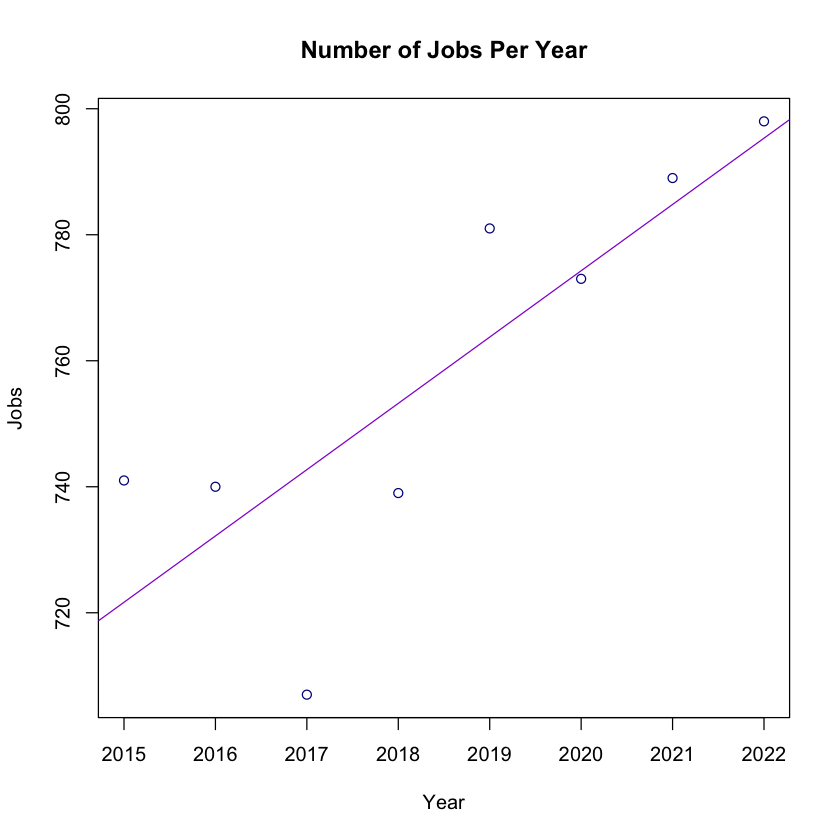

In [15]:
# Estimate of overall job growth in the jobs I'm interested in
years = split(QUAL, fiscal.year)
emp = employees(years)
emp = data.frame(Year=1:length(emp)+2014, Jobs=emp)
fit = lm(Jobs~Year, emp)

plot(emp, xlab="Year", ylab="Jobs", main="Number of Jobs Per Year", col="darkblue")
abline(fit, col="darkviolet")


cat("I estimate that there will be", as.integer(predict(fit, data.frame(Year=2022))-emp[emp$Year==2022,2]), "new jobs I can apply to next year.")



cat("\nWith a 90% confidence interval of the average yearly growh between [", confint(fit, level=0.90)[2,], "]")

In [16]:
# Lets look and see if there is any predicted growth in the kind of jobs I'm insterested in.
gen_class = QUAL$gen_class


growth = data.frame(job=character(0), new.jobs.2023=numeric(0), average.growth.rate=numeric(0), p.val=numeric(0))

jobs_by_year = data.frame(year=QUAL$fiscal.year, job=QUAL$gen_class)

for (job in unique(gen_class)){
    job_y = jobs_by_year[gen_class==job,]
    df = as.data.frame(table(job_y$year)) # Get a dataframe that counts of a particular for each year
    names(df) <- c("year", "count")
    if (nrow(df) == 8){
        df$year = as.numeric(df$year)
        df$year = (2014) + 1:nrow(df)  # adjust indicies so they line up with the data's year
        
        model = lm(count ~ year, data=df)
        sum = summary(model)
        coef = summary(model)$coefficients
        
        new_jobs_predicted = predict(model, data.frame(year=2023))- df[df$year==2022,2]
        growth_coefficient = coef[2, 1]  # B1
        p = coef[2, 4]

        
        # only add positive growth that we're statistially confident is occuring
        if (p <= 0.05& growth_coefficient > 0){
            l = list(job, new_jobs_predicted, growth_coefficient, p)
            growth[nrow(growth)+1,] = l
        }
    }
    

}
growth

,job,new.jobs.2023,average.growth.rate,p.val
,<chr>,<dbl>,<dbl>,<dbl>
1,CUSTODIAN,-1.75000,1.583333,0.02628355
2,RESEARCH ANALYST,-18.03571,5.380952,0.03370504


It looks like I'm confident that they'll be looking for custodians and research analysts at some point. But because 2022 seems to be such an outlier, my model expects some sort of regression-to-the-mean. So according to the data and my statistical models, I shouldn't be planning to get a job next year.

# Which Jobs That I Could Do Have The Most Fair Pay?

looking at the data, there are many jobs descriptions that are followed by numbers. I take this to mean that you can be promoted from one level to another. If I did one of these jobs (one's I'd be willing to do), it's important to me that I'm working with people that are being paid fairly—it makes for a less hostile work enviornment. In this case, I'll settle for the qualifyer that the salaries in that job are normally distributed. 

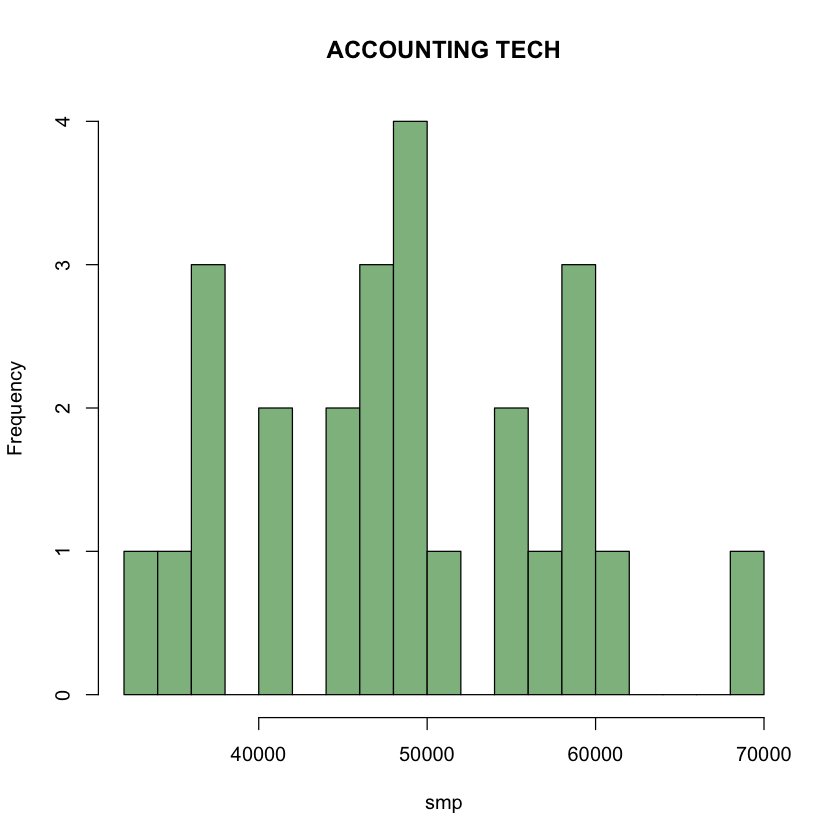

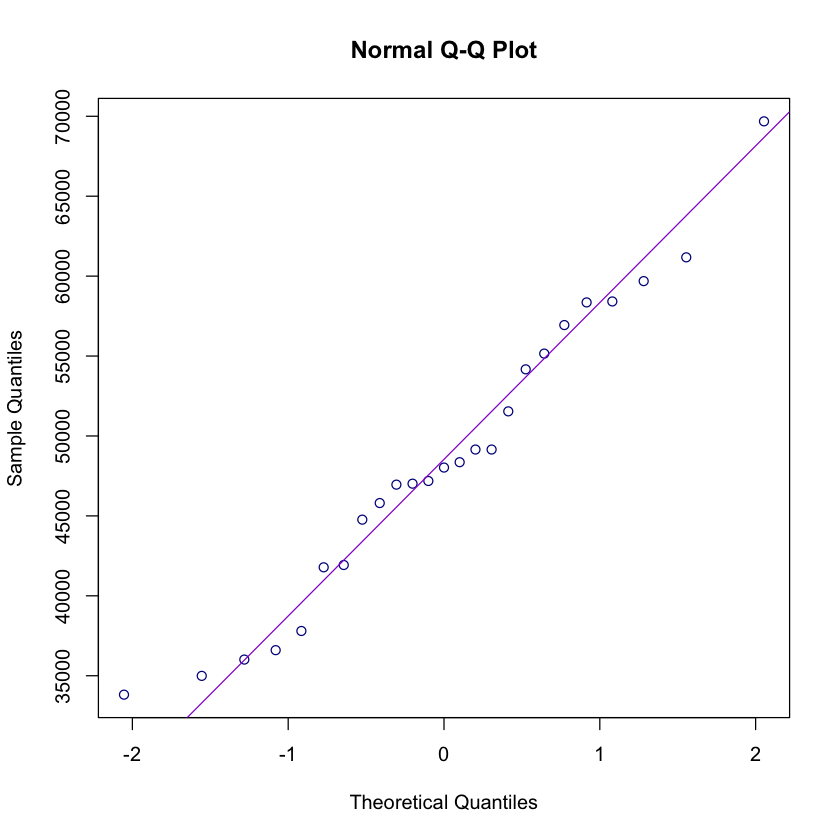

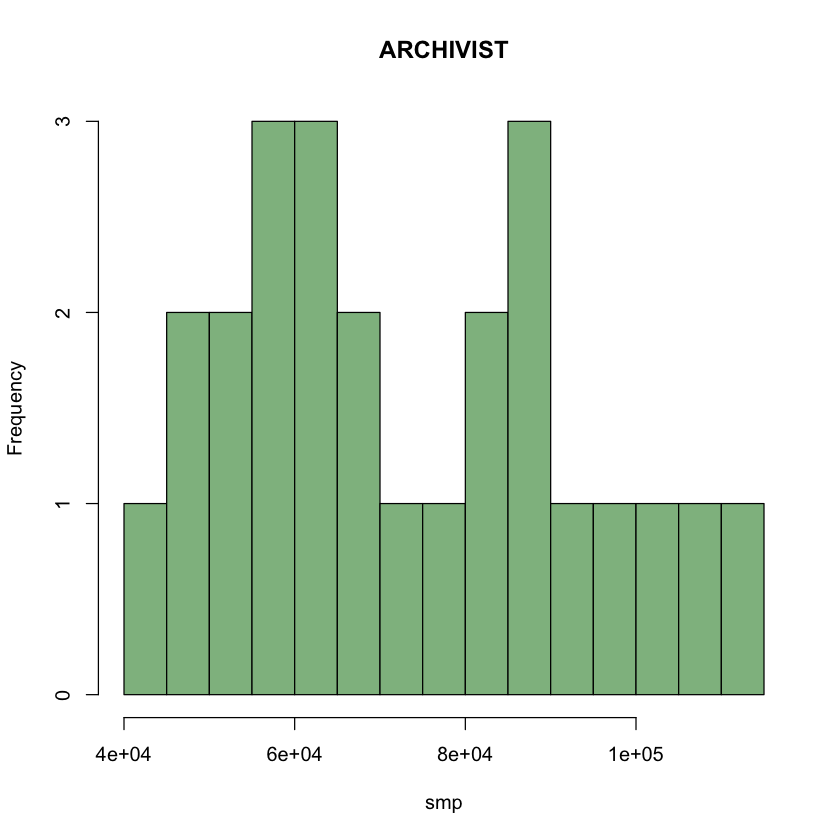

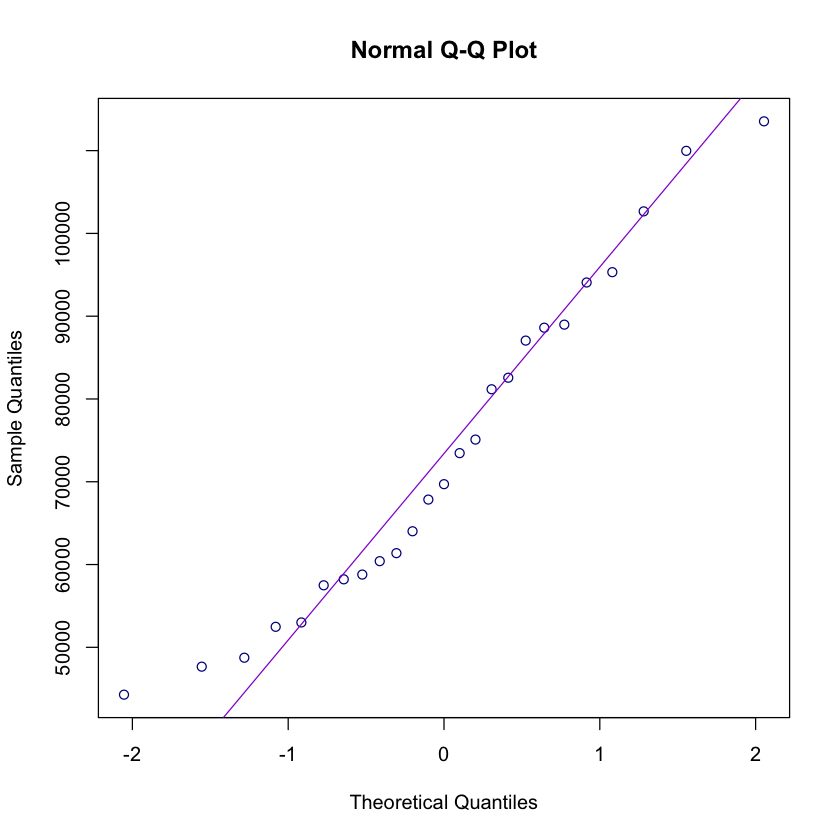

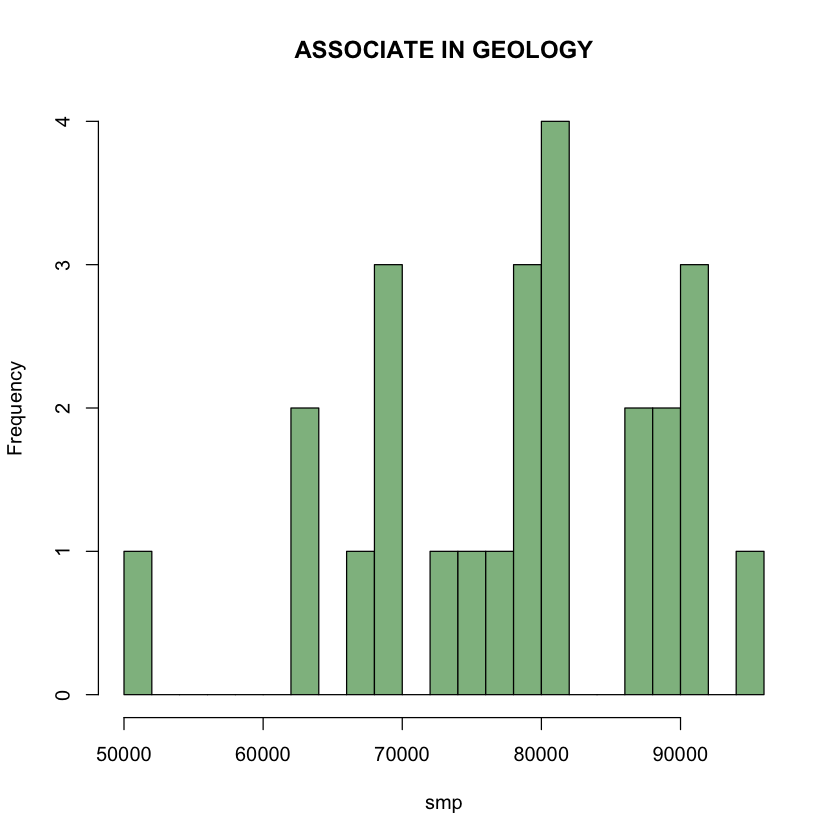

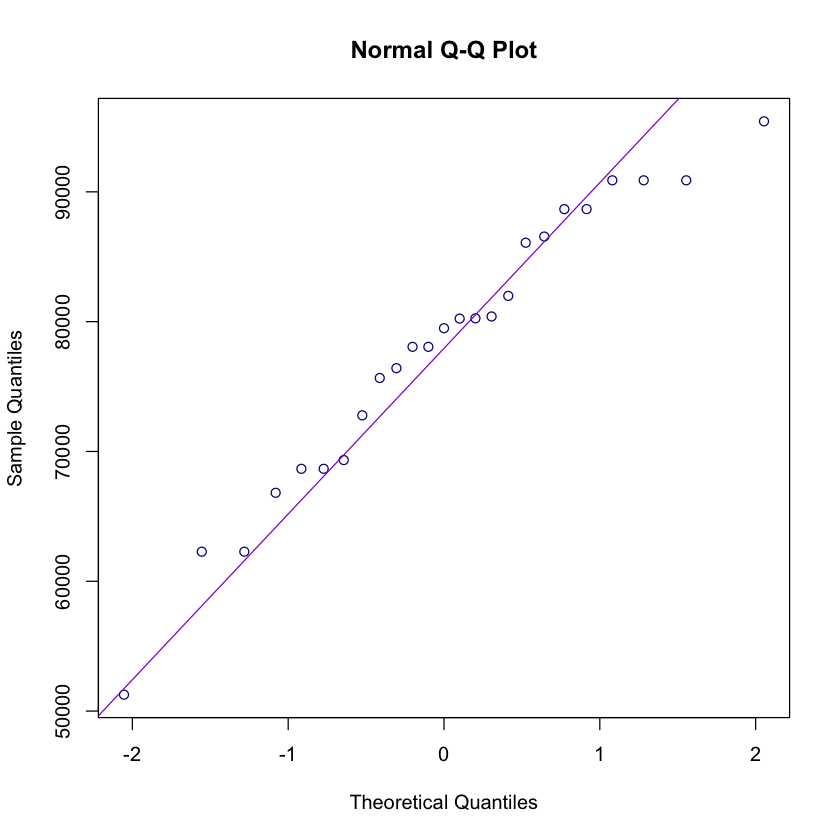

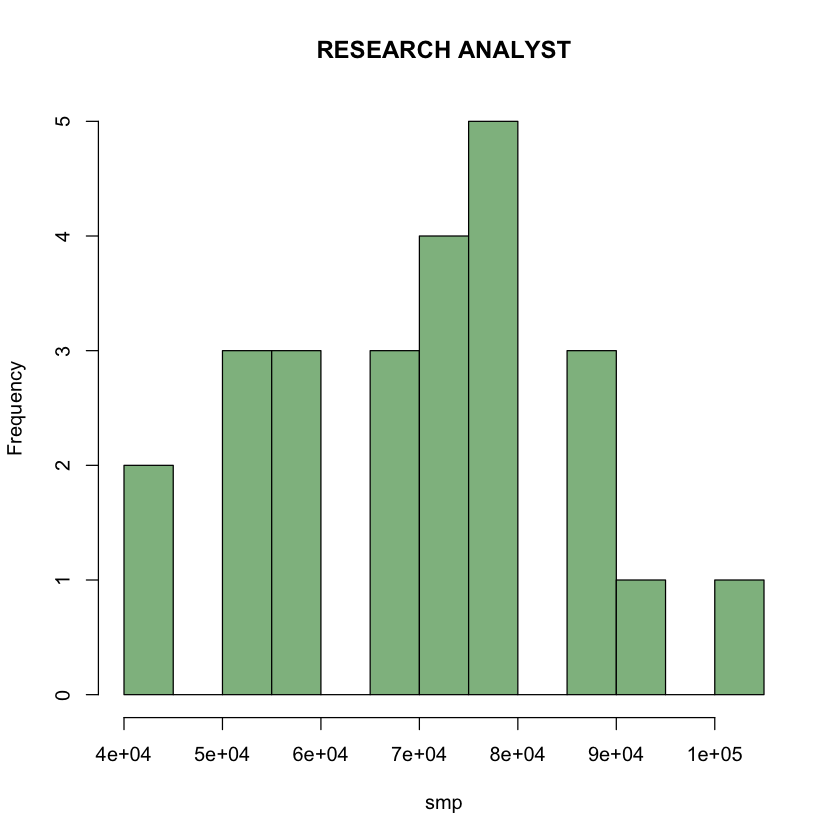

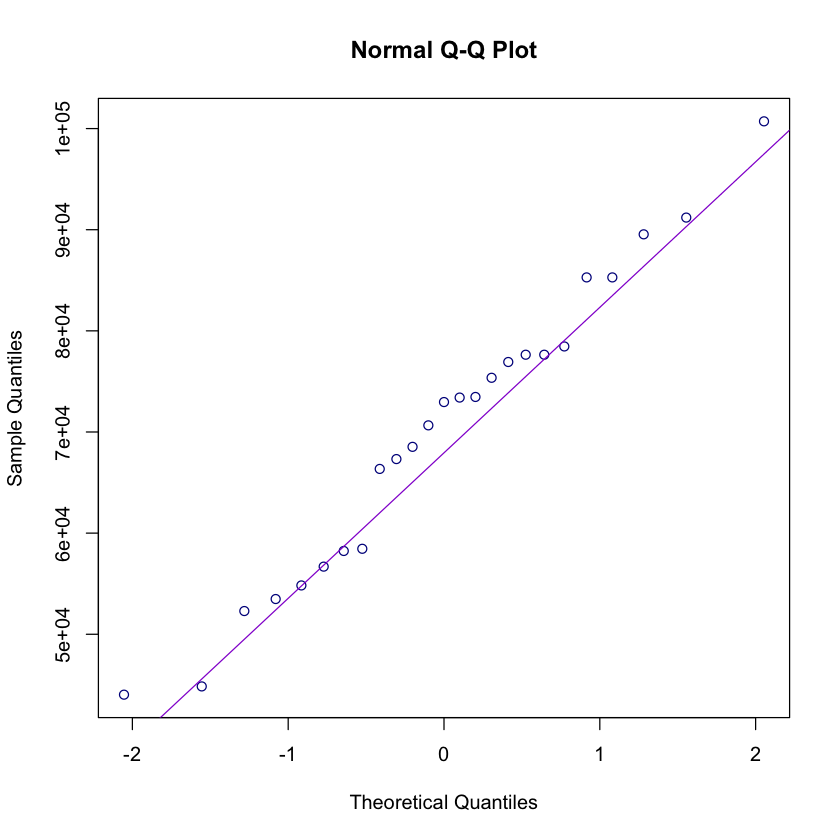

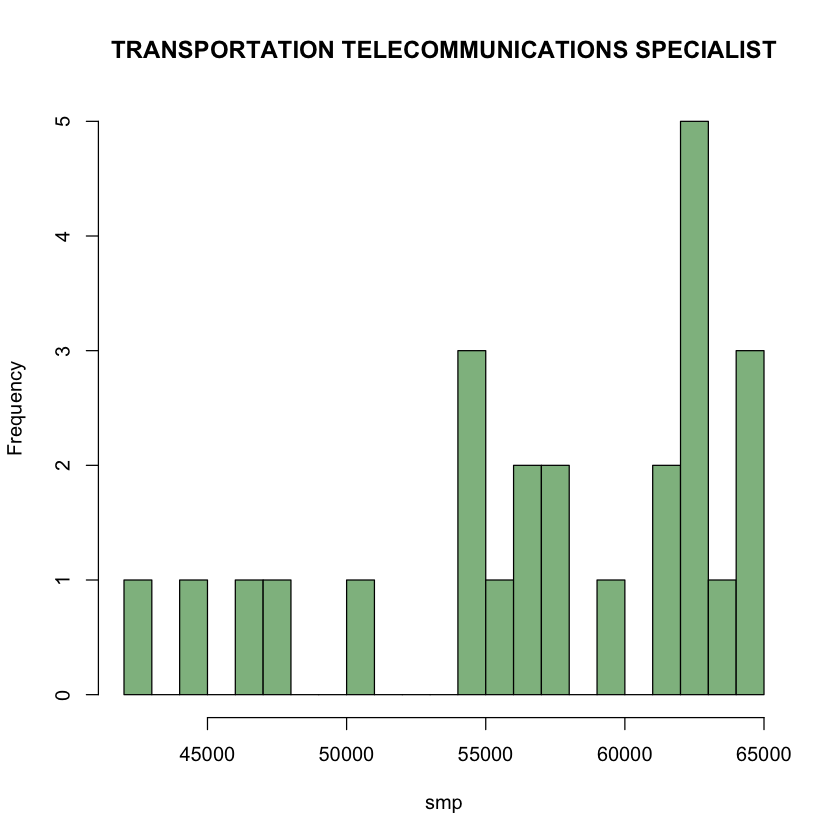

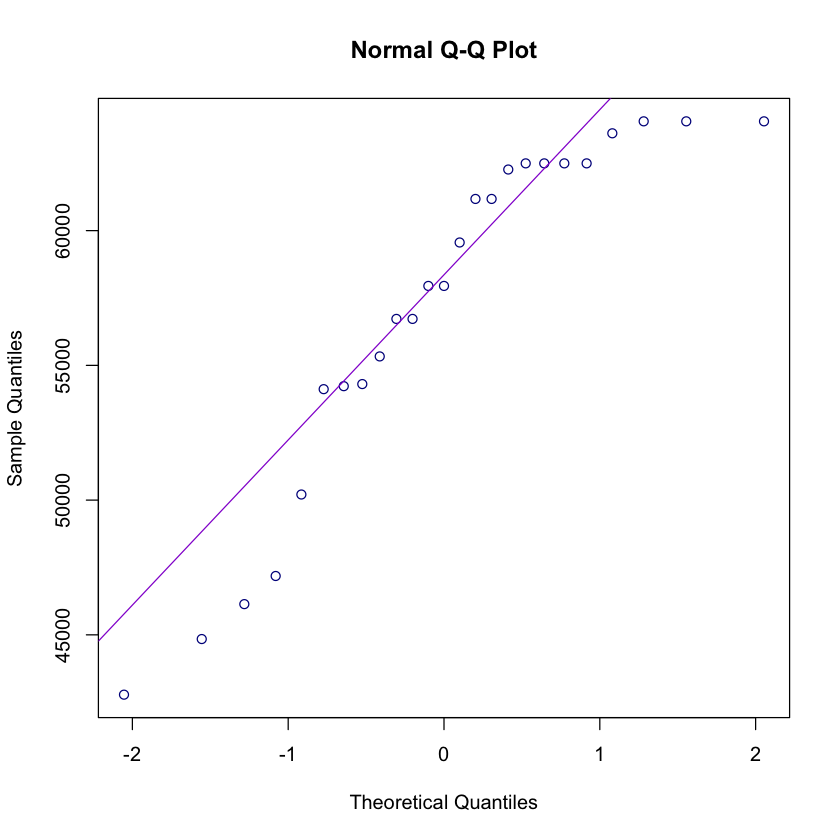

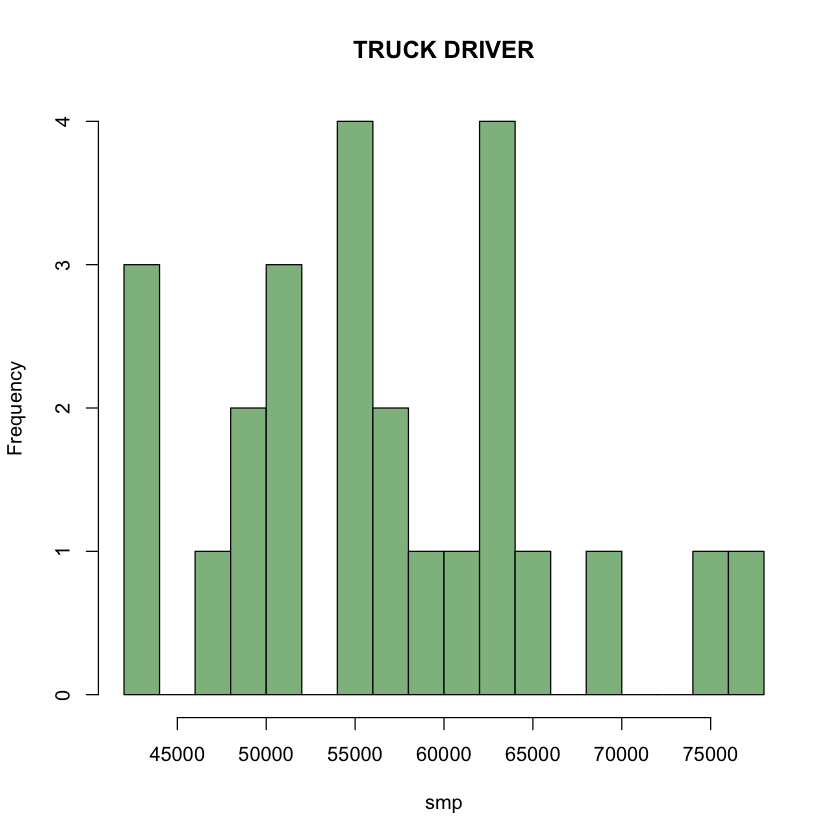

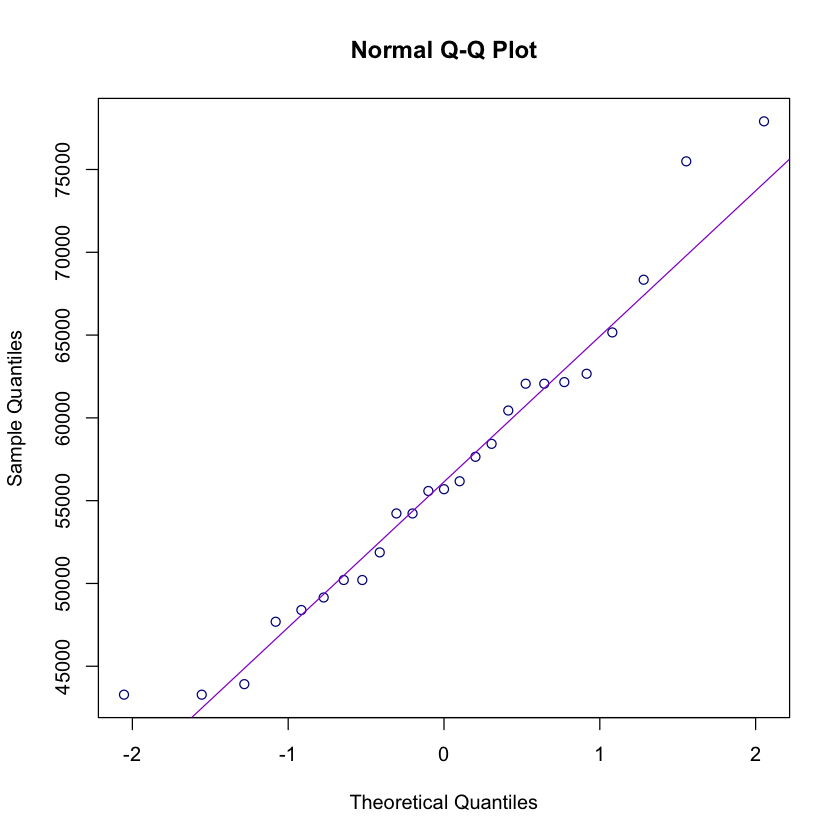

In [17]:
# Filter for jobs that end in numbers that I can run my analysis on
# We'll measure across all years and all departments, It's important that people doing the same job
# in different departments are paid with around the same distribution.

q = QUAL[str_detect(QUAL$classification, "\\d+$"),]
frequencies = as.data.frame(table(q$gen_class))

# We'll filter out any jobs that have less than 30 measurements to choose from
jobs = frequencies[frequencies$Freq >= 30,1]

samp10 <- function(data, dept_names){  # take 10 salary samples from each job
    new = data.frame(job=character(0), sample=numeric(0))
    for (name in dept_names){
        salaries = data[data$gen_class == name,4]
        for(x in 1:25){
            r = floor(runif(1, min=1, max=length(salaries)))
            row = list(name, salaries[r])
            salaries = salaries[-r]
            new[nrow(new)+1,] = row
        }
    }
    new
}

# We'll take a look at the histograms and q-q graphs of the jobs I can analyse, just to see how normal they appear.
samples = samp10(QUAL, jobs)
for (job in jobs){
    smp = samples[samples$job==job,2]
    hist(smp, main=job, breaks=20, col="darkseagreen")
    qqnorm(smp, col="darkblue")
    qqline(smp, col="darkviolet")
}

In [18]:
# let's get some stats on this: according to shapiro-wilk, which job is closest to a normal distribution
# re-using the random samples from above

norm_measures = data.frame(job=character(), shapiro.p = numeric())
for (job in jobs){
    smp = samples[samples$job==job,2]
    shap = shapiro.test(smp)
    norm_measures[nrow(norm_measures)+1,] = list(job, shap$p.value)
}
norm_measures[order(norm_measures$shapiro.p, decreasing=T),]

,job,shapiro.p
,<chr>,<dbl>
4,RESEARCH ANALYST,0.80949281
1,ACCOUNTING TECH,0.64147751
3,ASSOCIATE IN GEOLOGY,0.46369124
6,TRUCK DRIVER,0.34486630
2,ARCHIVIST,0.26270285
5,TRANSPORTATION TELECOMMUNICATIONS SPECIALIST,0.00694868


Well, it looks like **most** of the positions that I'm interested have strong evidence in favor of normality. Under my definition of egalitarianism, it looks like I'd be happy at any of these jobs except as a transportation telecom specialist.